In [1]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-8

# <u>VAE With 2D Convolutional Layers</u>

Here, we'll slightly change gears and show how to implement a VAE for the same task but using both 2D convolutional layers and dense layers.

In [2]:
import torch as tc
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

seed = 42
tc.manual_seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


Instead of manually finding how the dimension changes per convolutional layer, one could implement a function that just returns the output shape like so. The official PyTorch formula was used:
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [3]:
def conv2d_outshape(inpt_shape:tuple, filters, kernel_size, stride=1, padding=0, dilation=1):

    if isinstance(kernel_size, (float, int)):
        kernel_size = (kernel_size, kernel_size)
    if isinstance(stride, (float, int)):
        stride = (stride, stride)
    if isinstance(padding, (float, int)):
        padding = (padding, padding)
    if isinstance(dilation, (float, int)):
        dilation = (dilation, dilation)

    _, h_in, w_in = inpt_shape

    c_out = filters
    h_out = int((h_in + 2*padding[0] - dilation[0]*(kernel_size[0] - 1) -1)/stride[0] + 1)
    w_out = int((w_in + 2*padding[1] - dilation[1]*(kernel_size[1] - 1) -1)/stride[1] + 1)

    return c_out, h_out, w_out

The logic is exactly the same as in the previous notebook. The only difference is that we extract features using convolutional layers in the beginning and a dense layer in the end:

In [4]:
class ConvEncoder(nn.Module):

    def __init__(self, inpt_shape:tuple=(1, 28, 28), latent_dim:int=64):
        super(ConvEncoder, self).__init__()

        self.input_shape = inpt_shape
        self.latent_dim = latent_dim

        # first two layers:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)
        # determine the output shapes for conv layers:
        self.outconv1_shape = conv2d_outshape(inpt_shape=self.input_shape, filters=16, kernel_size=4, stride=2, padding=1)
        self.outconv2_shape = conv2d_outshape(inpt_shape=self.outconv1_shape, filters=32, kernel_size=4, stride=2, padding=1)
        self.outconv_dim = np.prod(self.outconv2_shape)
        # final layer:
        self.fc = nn.Linear(self.outconv_dim, 2*self.latent_dim)
        # activations:
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()

    def forward(self, x):
        x = x.view(-1, *self.input_shape)
        x = self.prelu1(self.conv1(x))
        x = self.prelu2(self.conv2(x))
        x = x.view(-1, self.outconv_dim)
        x = self.fc(x)
        mu = x[:, :self.latent_dim]
        logvar = x[:, self.latent_dim:]
        return mu, logvar

Correspondingly for decoder:

In [5]:
class ConvDecoder(nn.Module):

    def __init__(self, inpt_shape:tuple=(1, 28, 28), latent_dim:int=32):
        super(ConvDecoder, self).__init__()

        self.input_shape = inpt_shape
        self.latent_dim = latent_dim

        # determine the output shapes for the conv layers:
        self.outconv1_shape = conv2d_outshape(inpt_shape=self.input_shape, filters=16, kernel_size=4, stride=2, padding=1)
        self.outconv2_shape = conv2d_outshape(inpt_shape=self.outconv1_shape, filters=32, kernel_size=4, stride=2, padding=1)
        self.outconv_dim = np.prod(self.outconv2_shape)
        # first layer:
        self.rev_fc = nn.Linear(self.latent_dim, self.outconv_dim)
        # last two layers:
        self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.convt1 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1)
        # activations:
        self.prelu3 = nn.PReLU()
        self.prelu2 = nn.PReLU()

    def forward(self, z):
        x = self.prelu3(self.rev_fc(z))
        x = x.view(-1, *self.outconv2_shape)
        x = self.prelu2(self.convt2(x))
        return tc.sigmoid(self.convt1(x))

The rest is completely identical:

In [6]:
class ConvVAE(nn.Module):

    def __init__(self, inpt_shape:tuple=(1, 28, 28), latent_dim:int=64):
        super(ConvVAE, self).__init__()

        self.input_shape = inpt_shape
        self.input_dim = np.prod(inpt_shape)
        self.latent_dim = latent_dim

        self.encoder = ConvEncoder(inpt_shape=self.input_shape, latent_dim=self.latent_dim)
        self.decoder = ConvDecoder(inpt_shape=self.input_shape, latent_dim=self.latent_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        x_hat = self.decoder(z).view(-1, *self.input_shape)
        return x_hat, mu, logvar, z

    def sample(self, n: int):
        z = tc.randn(size=(n, self.latent_dim), device=device)
        return self.decoder(z).view(-1, *self.input_shape)

    @staticmethod
    def reparametrize(mu, logvar):
        std = tc.exp(.5*logvar)
        z = tc.randn_like(std)
        return std * z + mu

In [7]:
length, height = 28, 28  # MNIST is 28*28 images
input_shape = (1, height, length)
latent_dim_ = 64

batch_size = 128
epochs = 60
lr = 1e-3

In [8]:
model = ConvVAE(
    inpt_shape=input_shape,
    latent_dim=latent_dim_
).to(device)

_ = summary(model=model, input_data=tc.zeros(size=(batch_size, height, length)))

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvEncoder: 1-1                       [-1, 64]                  --
|    └─Conv2d: 2-1                       [-1, 16, 14, 14]          272
|    └─PReLU: 2-2                        [-1, 16, 14, 14]          1
|    └─Conv2d: 2-3                       [-1, 32, 7, 7]            8,224
|    └─PReLU: 2-4                        [-1, 32, 7, 7]            1
|    └─Linear: 2-5                       [-1, 128]                 200,832
├─ConvDecoder: 1-2                       [-1, 1, 28, 28]           --
|    └─Linear: 2-6                       [-1, 1568]                101,920
|    └─PReLU: 2-7                        [-1, 1568]                1
|    └─ConvTranspose2d: 2-8              [-1, 16, 14, 14]          8,208
|    └─PReLU: 2-9                        [-1, 16, 14, 14]          1
|    └─ConvTranspose2d: 2-10             [-1, 1, 28, 28]           257
Total params: 319,717
Trainable params: 319,717
Non-trainable params: 0

In [9]:
class DequantizeAndScale(tc.nn.Module):
    def __init__(self, scale_range=(0, 1)):
        super().__init__()
        self.min_val, self.max_val = scale_range

    def forward(self, img):
        img += tc.rand_like(img) / 256.0
        img *= (self.max_val - self.min_val) + self.min_val
        return img.clamp(0, 1)

transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    DequantizeAndScale()
])

In [10]:
# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

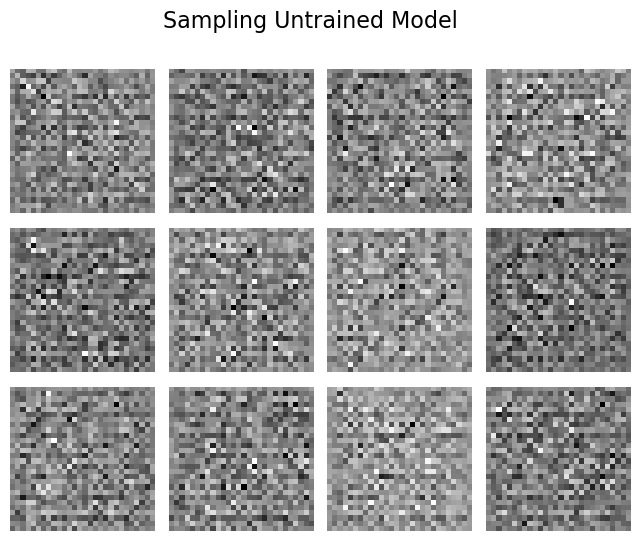

In [11]:
def sample_model(n_samples=12, title="None"):
    # Model sampling happens here:
    x_hat = model.sample(n_samples)
    x_hat = x_hat.cpu().detach().numpy().reshape(n_samples, height, length)
    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

model.eval()
sample_model(title="Sampling Untrained Model")

In [12]:
def loss_fn(x, x_hat, logvar, mu, beta=1):
    # Reconstruction loss:
    bce = F.binary_cross_entropy(input=x_hat, target=x)
    # KLD between Gaussian r.v.s:
    kld = -0.5 * tc.mean(1 + logvar - (mu**2) - tc.exp(logvar))
    return bce, beta*kld

100%|██████████| 469/469 [00:11<00:00, 39.21it/s]


Epoch 1/60 | BCE = 0.2938 | KLD = 0.0174


100%|██████████| 469/469 [00:12<00:00, 37.78it/s]


Epoch 2/60 | BCE = 0.2527 | KLD = 0.0148


100%|██████████| 469/469 [00:12<00:00, 37.99it/s]


Epoch 3/60 | BCE = 0.2445 | KLD = 0.0191


100%|██████████| 469/469 [00:12<00:00, 38.03it/s]


Epoch 4/60 | BCE = 0.2395 | KLD = 0.0220


100%|██████████| 469/469 [00:12<00:00, 38.49it/s]


Epoch 5/60 | BCE = 0.2351 | KLD = 0.0246


100%|██████████| 469/469 [00:12<00:00, 38.51it/s]


Epoch 6/60 | BCE = 0.2320 | KLD = 0.0269


100%|██████████| 469/469 [00:12<00:00, 37.90it/s]


Epoch 7/60 | BCE = 0.2297 | KLD = 0.0281


100%|██████████| 469/469 [00:12<00:00, 37.42it/s]


Epoch 8/60 | BCE = 0.2281 | KLD = 0.0293


100%|██████████| 469/469 [00:12<00:00, 38.45it/s]


Epoch 9/60 | BCE = 0.2267 | KLD = 0.0301


100%|██████████| 469/469 [00:12<00:00, 37.87it/s]


Epoch 10/60 | BCE = 0.2255 | KLD = 0.0307


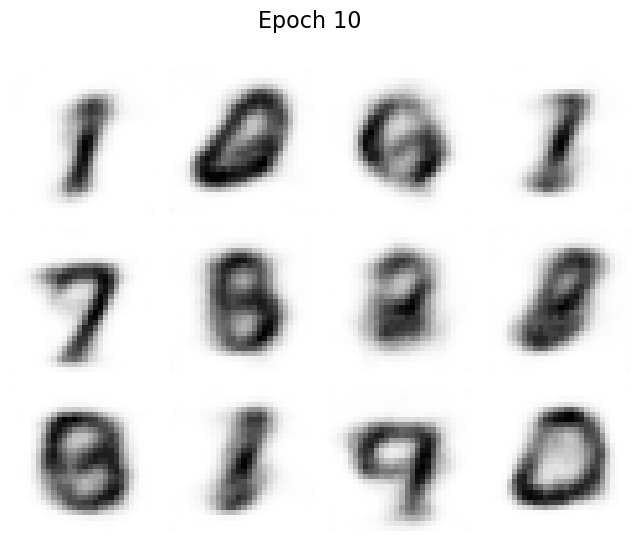

100%|██████████| 469/469 [00:12<00:00, 37.95it/s]


Epoch 11/60 | BCE = 0.2244 | KLD = 0.0316


100%|██████████| 469/469 [00:12<00:00, 38.41it/s]


Epoch 12/60 | BCE = 0.2235 | KLD = 0.0321


100%|██████████| 469/469 [00:12<00:00, 38.68it/s]


Epoch 13/60 | BCE = 0.2227 | KLD = 0.0328


100%|██████████| 469/469 [00:12<00:00, 37.66it/s]


Epoch 14/60 | BCE = 0.2217 | KLD = 0.0334


100%|██████████| 469/469 [00:12<00:00, 38.51it/s]


Epoch 15/60 | BCE = 0.2205 | KLD = 0.0342


100%|██████████| 469/469 [00:12<00:00, 37.64it/s]


Epoch 16/60 | BCE = 0.2190 | KLD = 0.0353


100%|██████████| 469/469 [00:12<00:00, 36.45it/s]


Epoch 17/60 | BCE = 0.2177 | KLD = 0.0360


100%|██████████| 469/469 [00:12<00:00, 37.45it/s]


Epoch 18/60 | BCE = 0.2170 | KLD = 0.0366


100%|██████████| 469/469 [00:12<00:00, 37.55it/s]


Epoch 19/60 | BCE = 0.2162 | KLD = 0.0371


100%|██████████| 469/469 [00:12<00:00, 37.65it/s]


Epoch 20/60 | BCE = 0.2160 | KLD = 0.0373


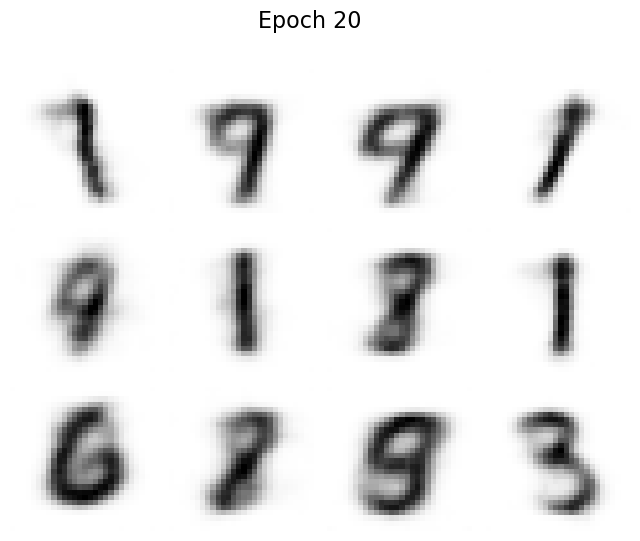

100%|██████████| 469/469 [00:12<00:00, 37.81it/s]


Epoch 21/60 | BCE = 0.2152 | KLD = 0.0377


100%|██████████| 469/469 [00:12<00:00, 38.08it/s]


Epoch 22/60 | BCE = 0.2150 | KLD = 0.0380


100%|██████████| 469/469 [00:12<00:00, 37.98it/s]


Epoch 23/60 | BCE = 0.2145 | KLD = 0.0384


100%|██████████| 469/469 [00:12<00:00, 37.68it/s]


Epoch 24/60 | BCE = 0.2140 | KLD = 0.0387


100%|██████████| 469/469 [00:12<00:00, 38.06it/s]


Epoch 25/60 | BCE = 0.2138 | KLD = 0.0387


100%|██████████| 469/469 [00:12<00:00, 38.09it/s]


Epoch 26/60 | BCE = 0.2133 | KLD = 0.0393


100%|██████████| 469/469 [00:12<00:00, 38.17it/s]


Epoch 27/60 | BCE = 0.2130 | KLD = 0.0394


100%|██████████| 469/469 [00:12<00:00, 38.23it/s]


Epoch 28/60 | BCE = 0.2127 | KLD = 0.0395


100%|██████████| 469/469 [00:12<00:00, 37.66it/s]


Epoch 29/60 | BCE = 0.2126 | KLD = 0.0396


100%|██████████| 469/469 [00:12<00:00, 38.25it/s]


Epoch 30/60 | BCE = 0.2123 | KLD = 0.0401


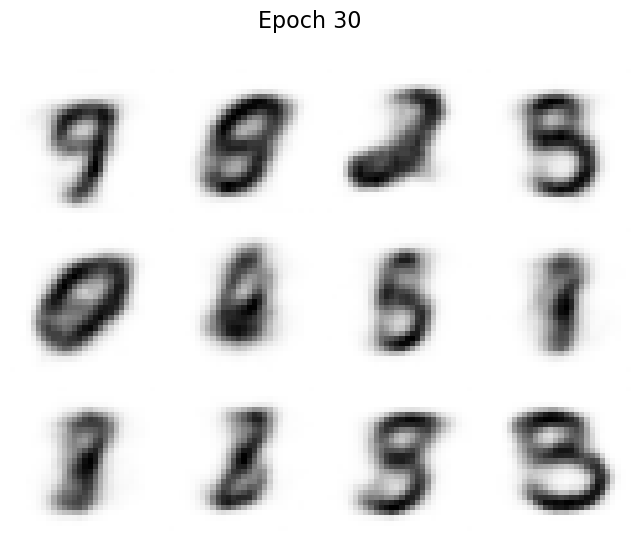

100%|██████████| 469/469 [00:12<00:00, 37.59it/s]


Epoch 31/60 | BCE = 0.2121 | KLD = 0.0399


100%|██████████| 469/469 [00:12<00:00, 37.90it/s]


Epoch 32/60 | BCE = 0.2119 | KLD = 0.0401


100%|██████████| 469/469 [00:12<00:00, 38.04it/s]


Epoch 33/60 | BCE = 0.2116 | KLD = 0.0401


100%|██████████| 469/469 [00:12<00:00, 37.71it/s]


Epoch 34/60 | BCE = 0.2114 | KLD = 0.0403


100%|██████████| 469/469 [00:12<00:00, 37.96it/s]


Epoch 35/60 | BCE = 0.2112 | KLD = 0.0406


100%|██████████| 469/469 [00:12<00:00, 38.72it/s]


Epoch 36/60 | BCE = 0.2111 | KLD = 0.0407


100%|██████████| 469/469 [00:12<00:00, 37.55it/s]


Epoch 37/60 | BCE = 0.2108 | KLD = 0.0408


100%|██████████| 469/469 [00:12<00:00, 38.04it/s]


Epoch 38/60 | BCE = 0.2108 | KLD = 0.0410


100%|██████████| 469/469 [00:12<00:00, 37.50it/s]


Epoch 39/60 | BCE = 0.2109 | KLD = 0.0407


100%|██████████| 469/469 [00:12<00:00, 37.61it/s]


Epoch 40/60 | BCE = 0.2106 | KLD = 0.0411


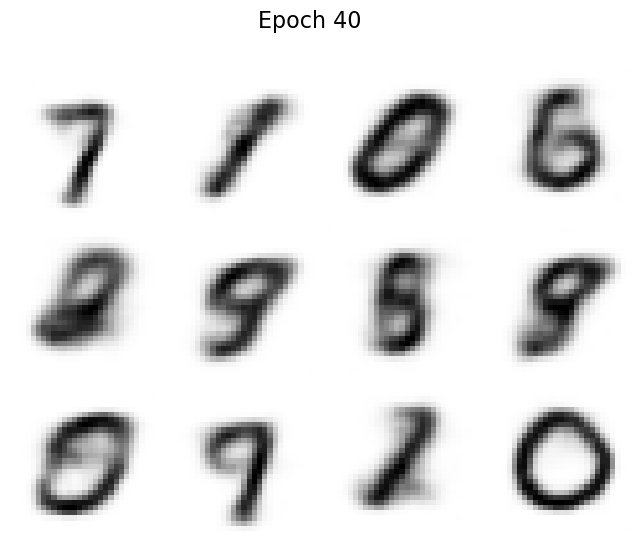

100%|██████████| 469/469 [00:12<00:00, 38.20it/s]


Epoch 41/60 | BCE = 0.2105 | KLD = 0.0412


100%|██████████| 469/469 [00:12<00:00, 37.74it/s]


Epoch 42/60 | BCE = 0.2105 | KLD = 0.0411


100%|██████████| 469/469 [00:12<00:00, 39.08it/s]


Epoch 43/60 | BCE = 0.2103 | KLD = 0.0412


100%|██████████| 469/469 [00:12<00:00, 38.31it/s]


Epoch 44/60 | BCE = 0.2101 | KLD = 0.0414


100%|██████████| 469/469 [00:11<00:00, 39.41it/s]


Epoch 45/60 | BCE = 0.2100 | KLD = 0.0415


100%|██████████| 469/469 [00:11<00:00, 40.48it/s]


Epoch 46/60 | BCE = 0.2098 | KLD = 0.0414


100%|██████████| 469/469 [00:11<00:00, 40.58it/s]


Epoch 47/60 | BCE = 0.2097 | KLD = 0.0416


100%|██████████| 469/469 [00:11<00:00, 40.23it/s]


Epoch 48/60 | BCE = 0.2097 | KLD = 0.0415


100%|██████████| 469/469 [00:11<00:00, 40.06it/s]


Epoch 49/60 | BCE = 0.2097 | KLD = 0.0418


100%|██████████| 469/469 [00:11<00:00, 41.02it/s]


Epoch 50/60 | BCE = 0.2095 | KLD = 0.0417


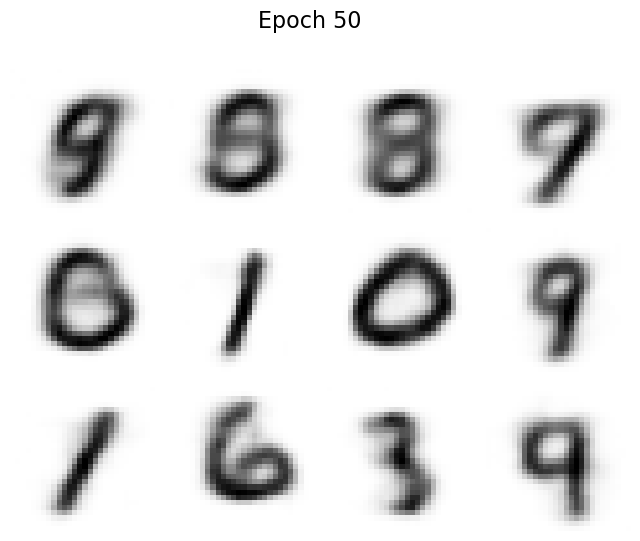

100%|██████████| 469/469 [00:11<00:00, 39.82it/s]


Epoch 51/60 | BCE = 0.2096 | KLD = 0.0417


100%|██████████| 469/469 [00:11<00:00, 40.21it/s]


Epoch 52/60 | BCE = 0.2093 | KLD = 0.0419


100%|██████████| 469/469 [00:11<00:00, 40.54it/s]


Epoch 53/60 | BCE = 0.2094 | KLD = 0.0420


100%|██████████| 469/469 [00:11<00:00, 40.54it/s]


Epoch 54/60 | BCE = 0.2092 | KLD = 0.0420


100%|██████████| 469/469 [00:11<00:00, 40.72it/s]


Epoch 55/60 | BCE = 0.2092 | KLD = 0.0420


100%|██████████| 469/469 [00:11<00:00, 40.97it/s]


Epoch 56/60 | BCE = 0.2090 | KLD = 0.0420


100%|██████████| 469/469 [00:11<00:00, 41.05it/s]


Epoch 57/60 | BCE = 0.2089 | KLD = 0.0421


100%|██████████| 469/469 [00:11<00:00, 41.05it/s]


Epoch 58/60 | BCE = 0.2088 | KLD = 0.0422


100%|██████████| 469/469 [00:11<00:00, 40.85it/s]


Epoch 59/60 | BCE = 0.2088 | KLD = 0.0423


100%|██████████| 469/469 [00:11<00:00, 40.80it/s]


Epoch 60/60 | BCE = 0.2087 | KLD = 0.0423


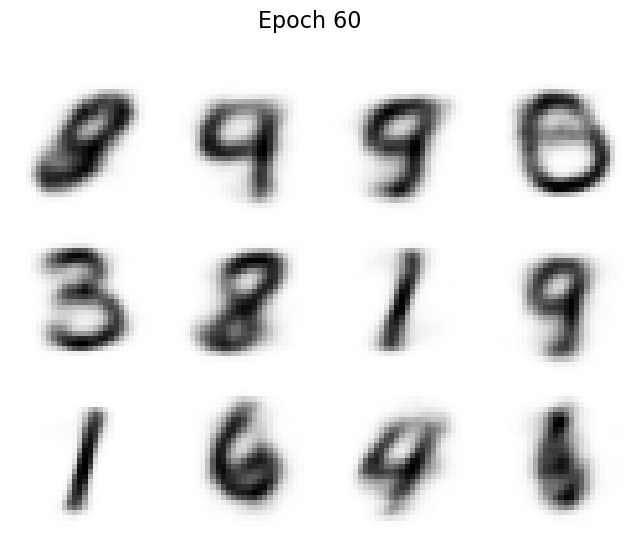

In [13]:
def train_loop():

    beta = 1
    print_every = 10
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses_bce = tc.zeros(epochs, device=device)
    losses_kld = tc.zeros(epochs, device=device)
    best_loss = 100

    if not os.path.isdir('saved_models'):
        os.makedirs('saved_models')

    model.train()
    for epoch in range(epochs):

        bce_loss = 0
        kld_loss = 0
        for x, _ in tqdm(train_loader):
            # zero gradients:
            optimizer.zero_grad()
            # put batch to device:
            x = x.to(device)
            # call model:
            x_hat, mu, logvar, z = model(x)
            # compute loss:
            bce, kld = loss_fn(x=x, x_hat=x_hat, logvar=logvar, mu=mu, beta=beta)
            # backpropagation:
            (bce + kld).backward()
            # update weights:
            optimizer.step()
            # save losses:
            bce_loss += bce.item()
            kld_loss += kld.item()

        # print, save & evaluate:
        bce_loss /= len(train_loader)
        kld_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} | BCE = {bce_loss:.4f} | KLD = {kld_loss:.4f}")
        losses_bce[epoch] = bce_loss
        losses_kld[epoch] = kld_loss
        if (epoch + 1) % print_every == 0:
            model.eval()
            sample_model(title=f"Epoch {epoch+1}")
            model.train()
        if bce_loss + kld_loss < best_loss:
            best_loss = bce_loss + kld_loss
            tc.save(model.state_dict(), f'saved_models/vae_fc.pt')

    return losses_bce, losses_kld

bces, klds = train_loop()

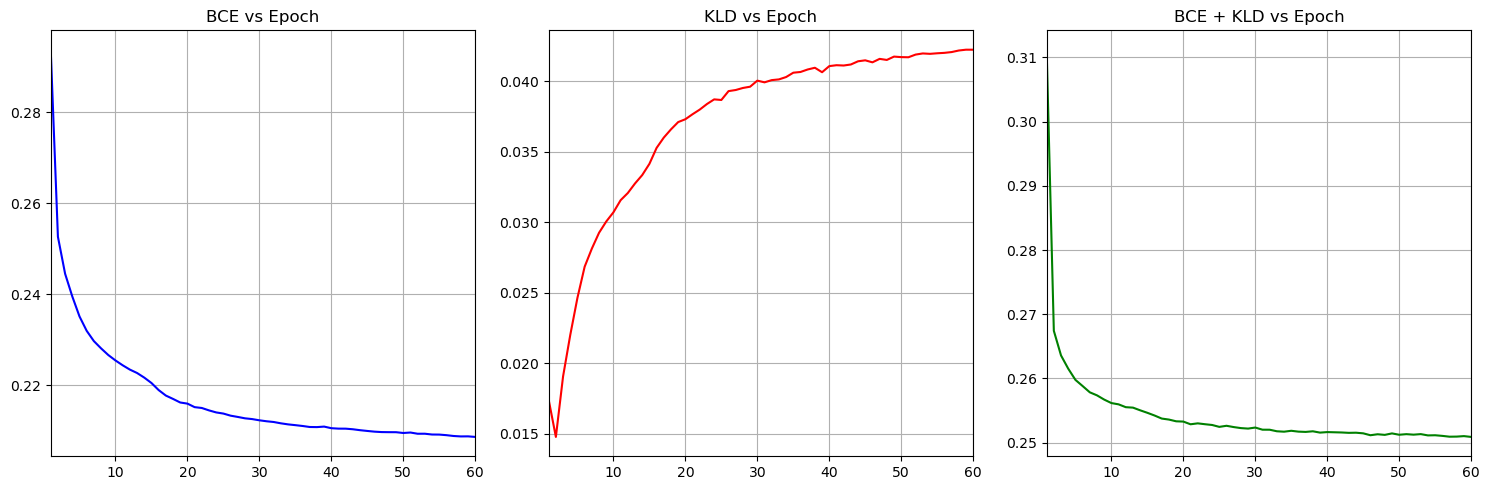

In [14]:
bces = bces.cpu().numpy()
klds = klds.cpu().numpy()
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
_, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(epoch_ax, bces, color='blue')
ax[0].set_xlim(1, epochs)
ax[0].set_title("BCE vs Epoch")
ax[0].grid()

ax[1].plot(epoch_ax, klds, color='red')
ax[1].set_xlim(1, epochs)
ax[1].set_title("KLD vs Epoch")
ax[1].grid()

ax[2].plot(epoch_ax, bces + klds, color='green')
ax[2].set_xlim(1, epochs)
ax[2].set_title("BCE + KLD vs Epoch")
ax[2].grid()

plt.tight_layout()
plt.show()
plt.close()